# **IMPORTS**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


# **Data Loading & Initial Inspection**

In [6]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("t_s1_am_6am.csv")

In [7]:
df.head()

,VV,VH,smap_am,soil_moisture
0,-9.058618,-15.982408,0.284554,0.301
1,-9.511266,-18.085192,0.218601,0.172
2,-10.926619,-19.470199,0.286454,0.485
3,-8.650778,-14.840568,0.407210,0.143
4,-6.633557,-13.470629,0.420252,0.375


In [8]:
df.shape

(30747, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30747 entries, 0 to 30746
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   VV             30747 non-null  float64
 1   VH             30747 non-null  float64
 2   smap_am        30747 non-null  float64
 3   soil_moisture  30747 non-null  float64
dtypes: float64(4)
memory usage: 961.0 KB


In [10]:
df.describe()

,VV,VH,smap_am,soil_moisture
count,30747.000000,30747.000000,30747.000000,30747.000000
mean,-9.195999,-16.417307,0.147262,0.412488
std,2.943375,3.413569,0.121603,17.746967
min,-26.670000,-35.349515,0.000000,0.000000
25%,-10.845618,-18.014890,0.071006,0.078000
50%,-9.104179,-15.783631,0.125384,0.174000
75%,-7.631939,-14.171636,0.202437,0.279000
max,5.057968,-4.289361,0.674961,1396.570000


# **Data Cleaning**

In [11]:
df.isnull().sum()

,0
VV,0
VH,0
smap_am,0
soil_moisture,0


In [12]:
df.duplicated().sum()

np.int64(13)

In [13]:
df[df.duplicated()]

,VV,VH,smap_am,soil_moisture
9463,-6.728263,-13.377953,0.409879,0.000
10316,-8.322000,-15.026160,0.000000,0.002
10610,-8.794185,-15.440610,0.304971,0.000
10712,-8.355611,-13.373356,0.299018,0.000
19230,-7.964323,-14.596812,0.467987,0.000
19372,-7.969918,-12.929211,0.432479,0.000
19648,-10.606812,-16.985178,0.000000,0.000
20755,-8.199110,-13.118798,0.438085,0.000
21546,-7.888458,-13.556169,0.347211,0.007
21720,-8.141978,-14.527202,0.334058,0.093


In [14]:
df.nunique()

,0
VV,28689
VH,28690
smap_am,23259
soil_moisture,642


In [ ]:
df.drop_duplicates(inplace=True)

# **EDA**

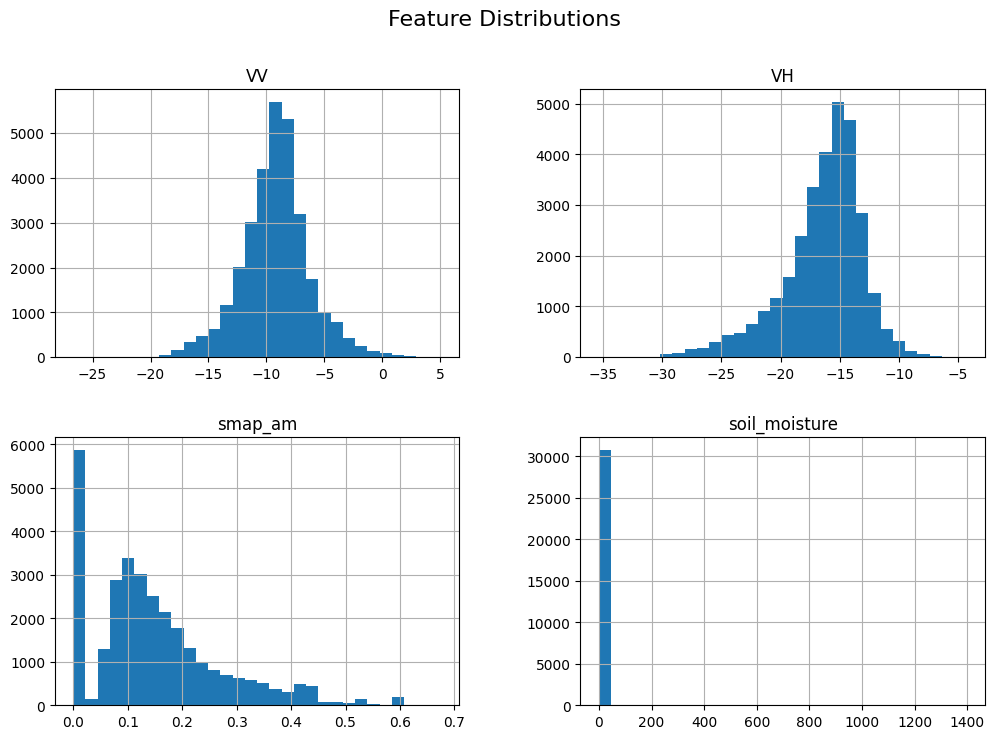

In [15]:
df.hist(figsize=(12,8), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

**Outliers**

In [16]:
# Show rows where soil moisture > 1 (physically unlikely)
outliers = df[df['soil_moisture'] > 1]
print("Number of suspicious rows:", outliers.shape[0])

Number of suspicious rows: 22


In [17]:
outliers.head(22)

,VV,VH,smap_am,soil_moisture
1081,-8.850859,-14.648176,0.214708,1395.560
1129,-8.606507,-14.642799,0.390132,2.332
1396,-8.306701,-14.297411,0.332181,2.413
1680,-8.085881,-14.569965,0.425239,2.358
1981,-8.396363,-15.222710,0.371598,2.199
2287,-8.670070,-14.729752,0.425239,2.249
2560,-8.477920,-14.669714,0.261589,2.292
3239,-8.667996,-15.518744,0.314346,2.264
3903,-8.678424,-15.233930,0.333234,2.231
4273,-8.480502,-14.471430,0.370183,2.193


In [18]:
print("Rows before:", len(df))
df_clean = df[(df['soil_moisture'] >= 0) & (df['soil_moisture'] <= 1)]
print("Rows after:", len(df_clean))

Rows before: 30747
Rows after: 30725


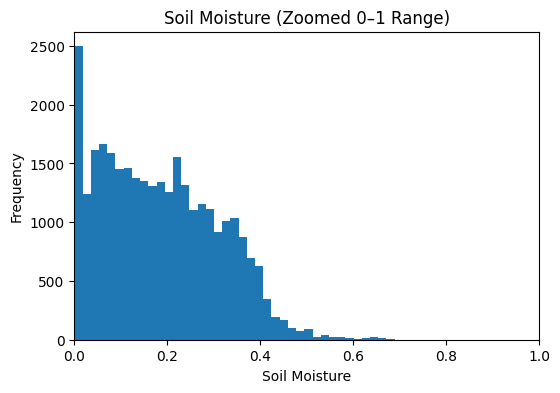

In [19]:
plt.figure(figsize=(6,4))
plt.hist(df_clean['soil_moisture'], bins=50)
plt.title("Soil Moisture (Zoomed 0–1 Range)")
plt.xlabel("Soil Moisture")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

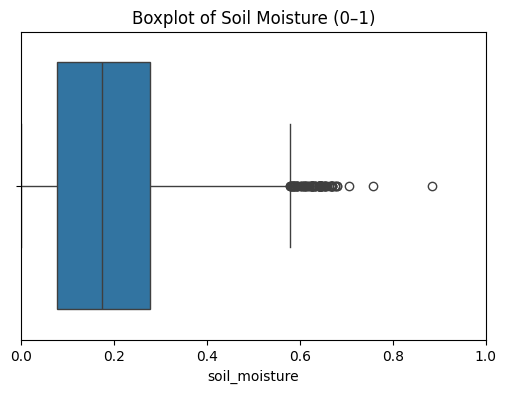

In [20]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_clean['soil_moisture'])
plt.title("Boxplot of Soil Moisture (0–1)")
plt.xlim(0, 1)
plt.show()

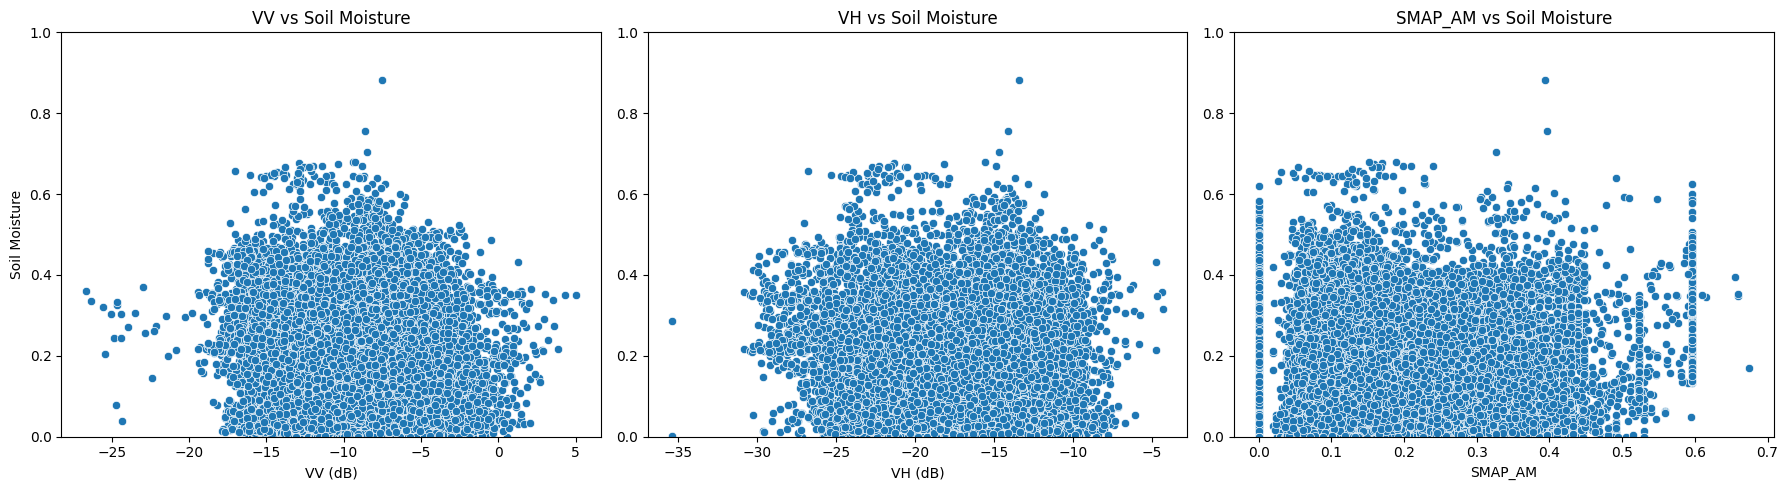

In [21]:
# Create figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: VV vs Soil Moisture
sns.scatterplot(ax=axes[0],x='VV',y='soil_moisture',data=df_clean)
axes[0].set_title("VV vs Soil Moisture")
axes[0].set_xlabel("VV (dB)")
axes[0].set_ylabel("Soil Moisture")
axes[0].set_ylim(0, 1)

# Plot 2: VH vs Soil Moisture
sns.scatterplot(ax=axes[1],x='VH',y='soil_moisture',data=df_clean)
axes[1].set_title("VH vs Soil Moisture")
axes[1].set_xlabel("VH (dB)")
axes[1].set_ylabel("")
axes[1].set_ylim(0, 1)

# Plot 3: SMAP vs Soil Moisture
sns.scatterplot(
    ax=axes[2],x='smap_am',y='soil_moisture',data=df_clean)
axes[2].set_title("SMAP_AM vs Soil Moisture")
axes[2].set_xlabel("SMAP_AM")
axes[2].set_ylabel("")
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

<Axes: >

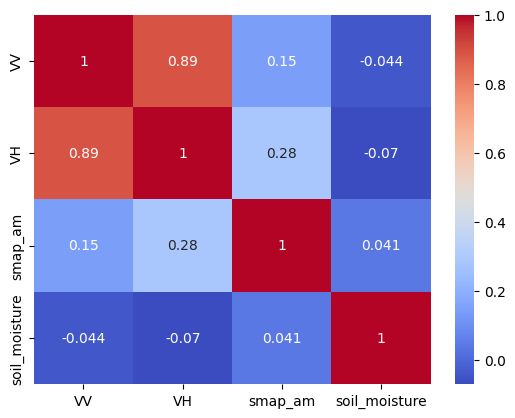

In [22]:
sns.heatmap(df_clean.corr(), annot=True, cmap="coolwarm")

In [47]:
df_clean.corr()["soil_moisture"].sort_values(ascending=False)

,soil_moisture
soil_moisture,1.000000
smap_am,0.040606
VV,-0.043982
VH,-0.070202


# **Data Preprocessing**

Feature Engineering

In [23]:
df = df_clean.copy()

# 1. Convert VV & VH from dB to Linear Scale
df["VV_lin"] = 10 ** (df["VV"] / 10)
df["VH_lin"] = 10 ** (df["VH"] / 10)

# 2. Interaction Features
df["VV_VH_interaction"] = df["VV_lin"] * df["VH_lin"]
df["VV_smap_interaction"] = df["VV_lin"] * df["smap_am"]
df["VH_smap_interaction"] = df["VH_lin"] * df["smap_am"]

# 3. Ratio Features
df["VV_VH_ratio"] = df["VV_lin"] / (df["VH_lin"] + 1e-6)
df["VH_VV_ratio"] = df["VH_lin"] / (df["VV_lin"] + 1e-6)
df["VV_minus_VH"] = df["VV"] - df["VH"]

# 4. Polynomial Features
df["VV_sq"] = df["VV_lin"] ** 2
df["VH_sq"] = df["VH_lin"] ** 2
df["smap_sq"] = df["smap_am"] ** 2

# 5. Log Features
df["log_smap"] = np.log1p(df["smap_am"])

In [24]:
corr_matrix = df.corr()
print(corr_matrix["soil_moisture"].sort_values(ascending=False))

soil_moisture          1.000000
VV_minus_VH            0.070120
smap_sq                0.063453
smap_am                0.040606
log_smap               0.035975
VV_VH_ratio            0.022708
VV_sq                 -0.005050
VH_smap_interaction   -0.005302
VV_smap_interaction   -0.007157
VH_sq                 -0.020389
VV_VH_interaction     -0.020519
VV_lin                -0.025726
VV                    -0.043982
VH_lin                -0.051735
VH_VV_ratio           -0.054246
VH                    -0.070202
Name: soil_moisture, dtype: float64


In [25]:
features = [
    "VV_lin",
    "VH_lin",
    "smap_am",
    "VV_minus_VH",
    "VV_VH_ratio",
    "VV_smap_interaction",
    "VH_smap_interaction",
    "smap_sq"
]

# **Train & Test Split**

In [26]:
X = df[features]
y = df["soil_moisture"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# **Model Building**

In [27]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=400, random_state=42),
    "SVR": SVR(kernel="rbf"),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

# **Model Training & Evaluation**

In [28]:
def train_and_evaluate(models, X_train, X_test, y_train, y_test):

    results = []

    scaler = StandardScaler()

    # Scale once (for SVR & KNN only)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():

        # Use scaled data only for SVR & KNN
        if name in ["SVR", "KNN"]:
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

        rmse = mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        results.append({
            "Model": name,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

    return pd.DataFrame(results).sort_values(by="RMSE")

In [29]:
results_df = train_and_evaluate(models, X_train, X_test, y_train, y_test)
results_df

,Model,RMSE,MAE,R2
1,GradientBoosting,0.014770,0.101863,0.072442
3,SVR,0.015031,0.102715,0.056052
0,RandomForest,0.015458,0.102639,0.029233
2,XGBoost,0.016783,0.106015,-0.053957
4,KNN,0.016816,0.106122,-0.056040


# **Hyper Parameter Tuning**

In [30]:
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 8, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)

print("Best RF Params:", rf_random.best_params_)

Best RF Params: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15}


In [31]:
gb_param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.03, 0.1],
    "max_depth": [3, 4],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "subsample": [0.8, 1.0]
}

gb_random = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_grid,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42
)

gb_random.fit(X_train, y_train)

print("Best GB Params:", gb_random.best_params_)

Best GB Params: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.1}


In [32]:
xgb_param_grid = {
    "n_estimators": [300, 500],
    "learning_rate": [0.03, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    XGBRegressor(random_state=42, verbosity=0),
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train, y_train)

print("Best XGB Params:", xgb_random.best_params_)

Best XGB Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


# **Model Evaluation**

In [33]:
best_gb = gb_random.best_estimator_
gb_pred = best_gb.predict(X_test)

print("Tuned GB RMSE:", mean_squared_error(y_test, gb_pred))
print("Tuned GB MAE:", mean_absolute_error(y_test, gb_pred))
print("Tuned GB R2:", r2_score(y_test, gb_pred))

Tuned GB RMSE: 0.014667007831994986
Tuned GB MAE: 0.10130651993612222
Tuned GB R2: 0.07893238649582235


In [34]:
best_rf = rf_random.best_estimator_
rf_pred = best_rf.predict(X_test)

print("Tuned RF RMSE:", mean_squared_error(y_test, rf_pred))
print("Tuned RF MAE:", mean_absolute_error(y_test, rf_pred))
print("Tuned RF R2:", r2_score(y_test, rf_pred))

Tuned RF RMSE: 0.014579157238669224
Tuned RF MAE: 0.10075566169364328
Tuned RF R2: 0.08444928109807193


In [35]:
best_xgb = xgb_random.best_estimator_
xgb_pred = best_xgb.predict(X_test)

print("Tuned XGB RMSE:", mean_squared_error(y_test, xgb_pred))
print("Tuned XGB MAE:", mean_absolute_error(y_test, xgb_pred))
print("Tuned XGB R2:", r2_score(y_test, xgb_pred))

Tuned XGB RMSE: 0.014743118184109942
Tuned XGB MAE: 0.10169720566346453
Tuned XGB R2: 0.07415276264967141


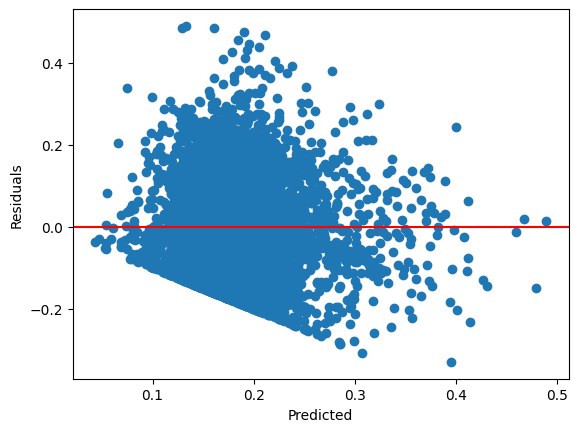

In [36]:
residuals = y_test - rf_pred

plt.scatter(rf_pred, residuals)
plt.axhline(0, color='r')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

# **DL Models**

**Building Model**

In [43]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Training Model**

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0194 - mae: 0.1120 - val_loss: 0.0152 - val_mae: 0.1025
Epoch 2/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1195 - mae: 0.1077 - val_loss: 0.0148 - val_mae: 0.1011
Epoch 3/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155 - mae: 0.1038 - val_loss: 0.0150 - val_mae: 0.1018
Epoch 4/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0186 - mae: 0.1041 - val_loss: 0.0147 - val_mae: 0.1014
Epoch 5/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - mae: 0.1040 - val_loss: 0.0156 - val_mae: 0.1048
Epoch 6/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - mae: 0.1043 - val_loss: 0.0148 - val_mae: 0.1015
Epoch 7/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0222 - mae: 0.1033 - val_loss: 0.0148 - val_mae: 0.1011
Epoch 8/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - mae: 0.1026 - val_loss: 0.0146 - val_mae: 0.1014
Epoch 9/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

**Evaluate Model**

In [45]:
y_pred_dl = model.predict(X_test_scaled).flatten()

print("DL RMSE:", mean_squared_error(y_test, y_pred_dl))
print("DL MAE:", mean_absolute_error(y_test, y_pred_dl))
print("DL R2:", r2_score(y_test, y_pred_dl))

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
DL RMSE: 0.014959593607888998
DL MAE: 0.10266776443560788
DL R2: 0.06055840828330028


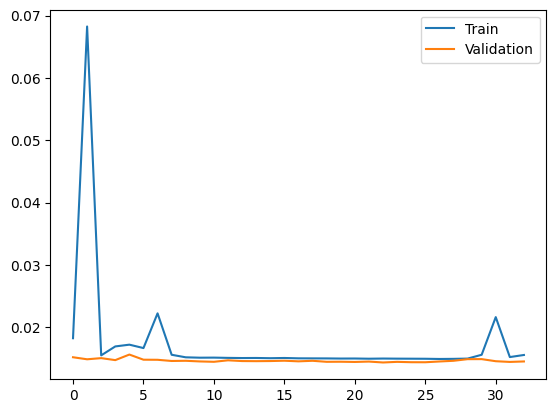

In [46]:
#Plot Training Curve

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

From your plot:

Training loss quickly drops

Validation loss stabilizes early

No major divergence

This means:

✅ Model is not overfitting
❌ But model cannot extract stronger signal

# **Conclusion**

Despite extensive modeling efforts including ensemble methods and deep learning architectures, the maximum achievable performance plateaued at R² ≈ 0.08. This indicates that VV, VH, and SMAP alone do not sufficiently capture the complexity of soil moisture variability. Additional environmental and temporal features are required for meaningful predictive performance.